In [13]:
import getpass 
password = getpass.getpass()

········


In [14]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.model_selection import train_test_split

## Getting the neccesary information - Yes/No rental in MAY2005

In [31]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query =  '''SELECT distinct f.title, f.rental_duration, f.rental_rate, f.length, f.rating,
max(CASE WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN 1 ELSE 0 END) AS rented_in_may
FROM film f
left JOIN inventory i ON f.film_id = i.film_id
left JOIN rental r ON i.inventory_id = r.inventory_id
group by f.film_id; ''';

In [32]:
data = pd.read_sql_query(query, engine)
data.head(10)

,title,rental_duration,rental_rate,length,rating,rented_in_may
0,ACADEMY DINOSAUR,6,0.99,86,PG,1
1,ACE GOLDFINGER,3,4.99,48,G,0
2,ADAPTATION HOLES,7,2.99,50,NC-17,0
3,AFFAIR PREJUDICE,5,2.99,117,G,1
4,AFRICAN EGG,6,2.99,130,G,1
5,AGENT TRUMAN,3,2.99,169,PG,1
6,AIRPLANE SIERRA,6,4.99,62,PG-13,0
7,AIRPORT POLLOCK,6,4.99,54,R,1
8,ALABAMA DEVIL,3,2.99,114,PG-13,0
9,ALADDIN CALENDAR,6,4.99,63,NC-17,0


In [33]:
data.shape

(1000, 6)

## Dataframe exploration

In [34]:
data.dtypes

title               object
rental_duration      int64
rental_rate        float64
length               int64
rating              object
rented_in_may        int64
dtype: object

In [35]:
data.rating.unique()
#to be encoded because they all have the same importance

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

In [36]:
data.rental_duration.unique()
# there is a difference in importance between 7days rental and 3... so better scale this column

array([6, 3, 7, 5, 4], dtype=int64)

In [40]:
data.isna().sum()

title              0
rental_duration    0
rental_rate        0
length             0
rating             0
rented_in_may      0
dtype: int64

In [41]:
numeric= data.select_dtypes('number')

## Corrolation

<Axes: >

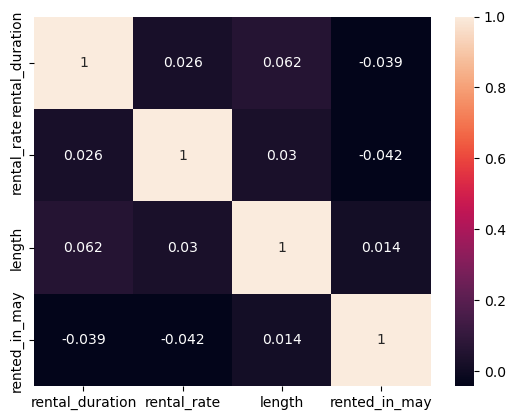

In [42]:
corr_matrix = numeric.corr()
sns.heatmap(corr_matrix,annot=True)
#there is no corrolation, which means we should keep all columns

## X-y split and train-test-split

In [46]:
data=data.drop('title', axis=1)
data.head(10)

,rental_duration,rental_rate,length,rating,rented_in_may
0,6,0.99,86,PG,1
1,3,4.99,48,G,0
2,7,2.99,50,NC-17,0
3,5,2.99,117,G,1
4,6,2.99,130,G,1
5,3,2.99,169,PG,1
6,6,4.99,62,PG-13,0
7,6,4.99,54,R,1
8,3,2.99,114,PG-13,0
9,6,4.99,63,NC-17,0


In [51]:
y = data['rented_in_may']
X = data.drop('rented_in_may', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

## Scaling

In [52]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_train_norm

,rental_duration,rental_rate,length
0,1.00,0.0,0.381295
1,0.25,1.0,0.071942
2,0.75,1.0,0.244604
3,1.00,1.0,0.733813
4,0.50,1.0,0.179856
...,...,...,...
795,0.75,0.5,0.640288
796,0.25,0.5,0.302158
797,0.75,0.5,0.338129
798,0.50,0.0,0.863309


In [53]:
X_test_num = X_test.select_dtypes(include = np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)
X_test_norm

,rental_duration,rental_rate,length
0,0.75,1.0,0.237410
1,0.75,0.5,0.194245
2,1.00,0.5,0.215827
3,0.50,0.5,0.388489
4,1.00,0.0,0.705036
...,...,...,...
195,0.00,0.5,0.143885
196,0.50,0.5,0.079137
197,0.25,0.0,0.971223
198,0.25,0.0,0.446043


## Encoding Categorical variables

In [56]:
from sklearn.preprocessing import OneHotEncoder

X_train_cat = X_train.select_dtypes(include = object)

encoder = OneHotEncoder(drop='first').fit(X_train_cat)

cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)

X_train_cat_encode = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns=cols)

X_train_cat_encode.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0


In [57]:
X_test_cat = X_test.select_dtypes(include = object)

cols = encoder.get_feature_names_out(input_features=X_test_cat.columns)

X_test_cat_encode = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns=cols)

X_test_cat_encode.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


## Rejoining X_train post transforimg 

In [59]:
#collect everything back into a dataframe by concat
X_train_transformed = pd.concat([X_train_cat_encode, X_train_norm],axis=1)
X_train_transformed

,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_duration,rental_rate,length
0,1.0,0.0,0.0,0.0,1.00,0.0,0.381295
1,0.0,0.0,0.0,0.0,0.25,1.0,0.071942
2,0.0,1.0,0.0,0.0,0.75,1.0,0.244604
3,0.0,0.0,1.0,0.0,1.00,1.0,0.733813
4,0.0,1.0,0.0,0.0,0.50,1.0,0.179856
...,...,...,...,...,...,...,...
795,0.0,1.0,0.0,0.0,0.75,0.5,0.640288
796,0.0,0.0,0.0,1.0,0.25,0.5,0.302158
797,0.0,1.0,0.0,0.0,0.75,0.5,0.338129
798,0.0,1.0,0.0,0.0,0.50,0.0,0.863309


In [60]:
X_test_transformed = pd.concat([X_test_cat_encode, X_test_norm],axis=1)
X_test_transformed

,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_duration,rental_rate,length
0,0.0,0.0,0.0,0.0,0.75,1.0,0.237410
1,1.0,0.0,0.0,0.0,0.75,0.5,0.194245
2,1.0,0.0,0.0,0.0,1.00,0.5,0.215827
3,0.0,0.0,0.0,0.0,0.50,0.5,0.388489
4,1.0,0.0,0.0,0.0,1.00,0.0,0.705036
...,...,...,...,...,...,...,...
195,0.0,1.0,0.0,0.0,0.00,0.5,0.143885
196,1.0,0.0,0.0,0.0,0.50,0.5,0.079137
197,0.0,0.0,0.0,1.0,0.25,0.0,0.971223
198,0.0,0.0,0.0,1.0,0.25,0.0,0.446043


## Model building of LogisticRegression type

In [64]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression().fit(X_train_transformed, y_train)

## Predictions and scoring

In [66]:
predictions_train = classification.predict(X_train_transformed)
classification.score(X_train_transformed, y_train)

0.6225

In [68]:
predictions_test = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.645

In [ ]:
# train and test scoring is close, which means the model is performing similarily for train and test data. 

In [69]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions_test)

array([[  0,  71],
       [  0, 129]], dtype=int64)

In [76]:
y_train.value_counts()

rented_in_may
1    498
0    302
Name: count, dtype: int64

In [77]:
y_test.value_counts()

rented_in_may
1    129
0     71
Name: count, dtype: int64

In [73]:
pd.DataFrame({'y_test':y_test, 'predictions_test':predictions_test})

,y_test,predictions_test
967,1,1
713,0,1
222,0,1
321,1,1
898,1,1
...,...,...
136,1,1
186,1,1
973,0,1
394,1,1


## Improving the model

In [ ]:
# the data is imbalanced leading the model to predict only for rented movies. 